# ***Coronavirus tweets - Text Classification / Sentiment Analysis***

[Kaggle Dataset](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/data)

This TP is relatively light coding-wise, please focus on the questions

⚠️Answers mindlessly copied from chatGPT will be penalized⚠️


For those running on a poetry environment, you will probably need to run:

```bash
!poetry add seaborn plotly sklearn xgboost
```

In [1]:
!poetry add seaborn plotly sklearn xgboost


Poetry could not find a pyproject.toml file in /Users/suying/Desktop or its parents


In [2]:
from google.colab import drive
import os


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

## ***Reading Data***

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/nlp_courses/nlp_courses/tp_2_vectorization_classification/data/Corona_NLP.csv", index_col=0)
print(df.shape)
df.head()

(44955, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## ***Data Exploration***

In [ ]:
class_labels = ["Extremely Negative", "Negative", "Neutral", "Positive", "Extremely Positive"]
category_orders = {"Sentiment": class_labels}

# use the value_counts function on the Sentiment column to print the class distribution # https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html
class_distribution = df['Sentiment'].value_counts()
print(class_distribution)
# use px.histogram to visualize the distribution, you can include the above parameters # https://plotly.com/python/histograms/

fig = px.histogram(df, x='Sentiment', category_orders=category_orders)
fig.show()


Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


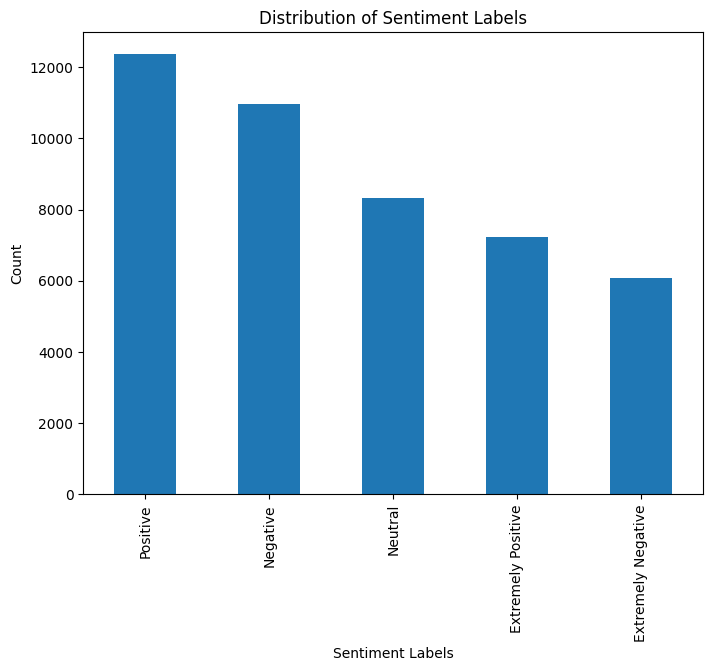

In [ ]:
# Visualize the distribution of sentiment labels

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.show()

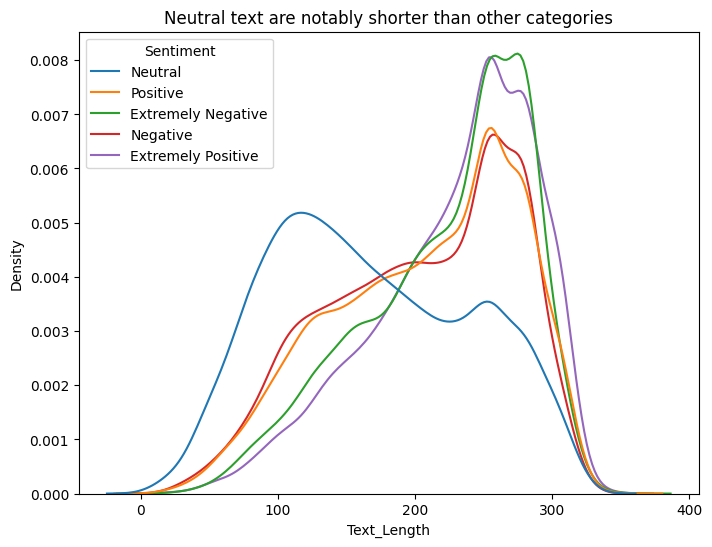

In [ ]:
df['Text_Length'] = df['OriginalTweet'].apply(len)
plt.figure(figsize=(8,6))

# use the sns.kdeplot function to visualize text length for each class # https://seaborn.pydata.org/generated/seaborn.kdeplot.html
sns.kdeplot(data=df, x='Text_Length', hue='Sentiment', common_norm=False)


plt.title("Neutral text are notably shorter than other categories")
plt.show()

What do you observe on this plot ? Could this be important in the future ?
* ***Your** thoughts here*<br>
First of all, we see that this picture has two peaks, one is around 100 words, and the other is around 300 words. Most of them are around 300 words. Neutral emotions generally have fewer words. Generally, the number of words with obvious emotions will not be too few, basically more than 200 words. <br>
I think it is important for future analysis to distinguish between different emotions.


## ***Preprocessing***

Here's the preprocessing function we'll use today:

* Removing twitter handles and url
* Tokenizing the text
* Lowering and removing non alphanumeric characters
* Removing stopwords
* Lemmatizing

In [ ]:
def remove_twitter_handles_url(text):
    twitter_handle_pattern = r'@[\w_]+'
    url_pattern = r'https?://\S+|www\.\S+'

    no_handle = re.sub(twitter_handle_pattern, '', text)
    cleaned_text = re.sub(url_pattern, '', no_handle)

    return cleaned_text

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    cleaned_text = remove_twitter_handles_url(text)
    # Tokenization
    tokens = word_tokenize(cleaned_text)
    # Remove punctuation and convert to lowercase
    words = [word.lower() for word in tokens if word.isalnum()]
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatization using WordNetLemmatizer
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

## ***Feature extraction***

Let's apply the Bag of Words encoding to some processed text and visualize the output vector

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
processed= df['OriginalTweet'][:200].apply(preprocess_text)
processed

0                                                       
1      advice talk neighbour family exchange phone nu...
2      coronavirus australia woolworth give elderly d...
3      food stock one empty please panic enough food ...
4      ready go supermarket covid19 outbreak paranoid...
                             ...                        
195    kept hearing boomer gon na travel cheap flight...
196    gt announces 10m loan fund administered provid...
197    pasta pasta sauce pizza sold grocery store eve...
198    panic fear fear mind killer pres working priva...
199    retail store closed end march keep staff custo...
Name: OriginalTweet, Length: 200, dtype: object

In [ ]:
bag_of_words = CountVectorizer() # instantiate count vectorizer # https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
processed_vectors = bag_of_words.fit_transform(processed)# fit and transform (at once) the preprocessed text (look through the documentation for the appropriate class method)
processed_vectors

<200x1561 sparse matrix of type '<class 'numpy.int64'>'
	with 3410 stored elements in Compressed Sparse Row format>

What do the dimensions of the Bag of Words vectors correspond to ?
* Dimension 1: This corresponds to the first unique word in the vocabulary. It represents the frequency of that word in the text documents.
* Dimension 2: This corresponds to the second unique word  in the vocabulary. 


In [ ]:
bag_of_words_df = pd.DataFrame(processed_vectors.toarray())# convert the processed vectors to arrays (look at the "examples" section in the docs) and create a dataframe based on those vectors
bag_of_words_df

,0,1,2,3,4,5,6,7,8,9,...,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
color_continuous_scale='RdBu_r'

# use the px.imshow plotly function to visualize your dataframe, use the above colorscale
# https://plotly.com/python/imshow/

px.imshow(bag_of_words_df, color_continuous_scale='RdBu_r', title="Representation of [200 x 1561] Bag of Words encodings")

Looking at the vectorized text:
* Is the term "sparse representation" justified ?
    * ***Your** thoughts here* <br>
    Bag of Words representations are typically sparse because the document contains only a subset of words from the vocabulary and the rest are zero.
When visualizing the BoW matrix using px.imshow, what is shown is a dense representation (non-zero values), which may not accurately reflect its sparsity.
* Does this look efficient ?
    * ***Your** thoughts here* <br>
    The efficiency of BoW depends on the use case and vocabulary size. It is effective for some natural language processing tasks, but may not be efficient enough with large vocabulary or large number of documents.
In practice, dimensionality reduction techniques can be used to handle the high-dimensional nature of BoW representations more efficiently.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf =TfidfVectorizer() # repeat with a TDIDF vectorizer
processed_vectors = tfidf.fit_transform(processed)
#fit and transform, same code as previously
processed_vectors

<200x1561 sparse matrix of type '<class 'numpy.float64'>'
	with 3410 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_df = pd.DataFrame(processed_vectors.toarray())# create a dataframe of vectors as previously
tfidf_df

,0,1,2,3,4,5,6,7,8,9,...,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,0.235625,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# use imshow to plot the vector representations
fig = px.imshow(tfidf_df, color_continuous_scale='RdBu_r', title="TF-IDF Vector Representations")
fig.show()

## ***Label encoding and train/test split***

Now that we've vectorized the text, we want to encode the class labels and create a train/test split

In [3]:
label_encoder = LabelEncoder()# instantiate a label encoder # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
df['Sentiment_enc'] = label_encoder.fit_transform(df['Sentiment'])# fit and transform the encoder on labels

NameError: name 'LabelEncoder' is not defined

In [ ]:
# Split the data into training and testing sets
X =df['OriginalTweet']  #  Assuming 'OriginalTweet' is your feature
y = df['Sentiment_enc']#  Assuming 'Sentiment_enc' is your encoded target label

test_size=0.2
random_state=42

# use the train_test_split function with the above test size and random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split

## ***Model Definition***

Now we'll define a pipeline. This pipeline will take raw tweets as input, preprocess and vectorize them, before fitting a classification model to it.
Use the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) to instantiate your pipeline:
* Step 1: [Count vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), ***using our preprocessing function as preprocessor***
* Step 2: A classification model, here a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)

In [ ]:
text_clf = Pipeline([
('vectorizer', CountVectorizer(preprocessor=preprocess_text)),
('classifier', MultinomialNB())
])

## ***Training***

In [ ]:
# fit the pipeline to the training data
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(preprocessor=<function preprocess_text at 0x7e3e8db68670>)),
                ('classifier', MultinomialNB())])

## ***Prediction***

In [ ]:
y_pred = text_clf.predict(X_test)# Use the pipeline to run predictions on the test data

## ***Results visualization***

In [ ]:
# styling the confusion matrix
confusion_matrix_kwargs = dict(
    text_auto=True,
    title="Confusion Matrix", width=1000, height=800,
    labels=dict(x="Predicted", y="True Label"),
    x=class_labels,
    y=class_labels,
    color_continuous_scale='Blues'
)

def report(y_true, y_pred, class_labels):
    print(classification_report(y_true, y_pred, target_names=class_labels))
    # print a classification report of the predictions # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn-metrics-classification-report
    # create a confusion matrix and pass it to imshow to visualize it # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
    # (the confusion_matrix_kwargs are here for styling only)
    conf_matrix = confusion_matrix(y_true, y_pred)
    fig = px.imshow(
        conf_matrix,
        **confusion_matrix_kwargs
        )
    fig.show()

In [4]:
class_labels = label_encoder.inverse_transform(range(5))
# call the report function to visualize the classification results, use the above class_labels
report(y_test, y_pred, class_labels)


NameError: name 'label_encoder' is not defined

## ***What happened here ?***
Looking at the confusion matrix:

* What are some examples of classes that are confused with one another ?
    * ***Your** thoughts here*<br>
    To identify categories that are often confused with each other, examine the off-diagonal elements of the confusion matrix. These elements represent categorisation errors.<br>
    For example, if you see non-zero values in the rows corresponding to the category positive and the columns corresponding to the category neutral, this means that some instances of the category positive have been incorrectly classified as category neutral.
* The "Neutral" class has 68% precision and 34% recall, what does this mean ?
    * ***Your** thoughts here*<br>
    recision (68%): This means that when the model predicts an instance as "Neutral," it is correct about 68% of the time. In other words, out of all the instances predicted as "Neutral," 68% are actually "Neutral."
    Recall (34%): This indicates that the model is capturing only 34% of the actual "Neutral" instances correctly. In other words, out of all the true "Neutral" instances, the model is correctly identifying only 34% of them.<br>
    The trade-off between precision and recall is common in classification tasks. In this case, the model has a reasonably high precision for the "Neutral" class, but it misses a significant portion of the actual "Neutral" instances (low recall).

## ***Let's try with TD-IDF***

But first, let's define a [class](https://www.w3schools.com/python/python_classes.asp) that will make iterating through different architectures and vectorizers a lot faster

In [ ]:
class Model:
    def __init__(self, X, y, model_architecture, vectorizer, random_seed=42, test_size=0.2) -> None:
        self.X = X
        self.y = y
        self.model_instance = model_architecture
        self.vectorizer = vectorizer
        self.random_seed = random_seed
        self.test_size = test_size

        self.pipeline = Pipeline([
            ('vectorizer', self.vectorizer(preprocessor=self.preprocess)),
            ('classifier', self.model_instance)
        ])# the pipeline as defined previously

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, random_state=self.random_seed
        )# train test split using the above X, y, test_size and random_state

    def preprocess(self, text):
        def remove_twitter_handles_url(text):
            twitter_handle_pattern = r'@[\w_]+'
            url_pattern = r'https?://\S+|www\.\S+'

            no_handle = re.sub(twitter_handle_pattern, '', text)
            cleaned_text = re.sub(url_pattern, '', no_handle)

            return cleaned_text

        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        cleaned_text = remove_twitter_handles_url(text)
        tokens = word_tokenize(cleaned_text)
        words = [word.lower() for word in tokens if word.isalnum()]
        words = [word for word in words if word not in stop_words]
        words = [lemmatizer.lemmatize(word) for word in words]

        return ' '.join(words)

    def fit(self):
        self.pipeline.fit(self.X_train, self.y_train)# fit self.pipeline to the training data

    def predict(self):
        return self.pipeline.predict(self.X_test)


    def predict_proba(self):
        return self.pipeline.predict_proba(self.X_test)



    def report(self):
        # the report function as defined previously
        class_labels = label_encoder.inverse_transform(range(5))
        y_pred = self.predict()
        confusion = confusion_matrix(y_test, y_pred)

        print(classification_report(self.y_test, y_pred, target_names=class_labels))
        print("Confusion Matrix:")
        print(confusion)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
# instantiate the Model class with text and labels (X and y), a multinomial naive bayes model and a tfidf vectorizer
# fit the model
# predict and generate classification report
# Instantiate the Model class
model = Model(X, y, MultinomialNB(), TfidfVectorizer)

# Fit the model to the training data
model.fit()


# Predict and generate a classification report


model.report()

                    precision    recall  f1-score   support

Extremely Negative       0.86      0.04      0.08      1189
Extremely Positive       0.88      0.05      0.09      1457
          Negative       0.40      0.48      0.44      2204
           Neutral       0.80      0.10      0.17      1681
          Positive       0.35      0.86      0.50      2460

          accuracy                           0.39      8991
         macro avg       0.66      0.31      0.26      8991
      weighted avg       0.60      0.39      0.30      8991

Confusion Matrix:
[[  48    0  837    7  297]
 [   0   71   50    1 1335]
 [   7    0 1060   20 1117]
 [   1    0  358  164 1158]
 [   0   10  317   14 2119]]


* What is the model's behaviour ?
    * ***Your** thoughts here*. The behavior of the model differs across categories. From the confusion matrix and classification report, the neutral category performs worse, while the positive and negative categories perform better.
* Is this a sign of overfitting, underfitting ?
    * ***Your** thoughts here* The problem may be insufficient complexity of the model, resulting in underfitting. The model may not be able to capture complex relationships in the data.
* Why could the model be biased towards the positive and negative classes ?
    * ***Your** thoughts here*. Possibly affected by feature engineering, certain words or features may be more easily associated with positive or negative emotions.
* Naive Bayes assumes that features (words) are conditionally independent given the class label. Between the two encodings we've tried, which one seems to better satisfy this assumption ?
    * ***Your** thoughts here*. Naive Bayes is more suitable to use "Bag of Words" (BoW) encoding because it assumes that features are independent, while BoW encoding actually assumes that each word is independent in the text. TF-IDF coding takes into account the importance of vocabulary but does not satisfy the independence assumption. Therefore, from the perspective of the independence assumption, BoW is more suitable for the naive Bayes model.

In [ ]:
# instantiate the Model class with text and labels (X and y), a logistic regression model and a tfidf vectorizer
# fit the model
# predict and generate classification report
from sklearn.linear_model import LogisticRegression

# Instantiate the Model class with text and labels (X and y), a logistic regression model, and a TF-IDF vectorizer
logistic_model = Model(X, y, LogisticRegression(), TfidfVectorizer)

# Fit the model to the training data
logistic_model.fit()

# Predict and generate a classification report
logistic_model.report()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



                    precision    recall  f1-score   support

Extremely Negative       0.63      0.49      0.55      1189
Extremely Positive       0.68      0.55      0.61      1457
          Negative       0.51      0.52      0.52      2204
           Neutral       0.63      0.67      0.65      1681
          Positive       0.52      0.61      0.56      2460

          accuracy                           0.57      8991
         macro avg       0.59      0.57      0.58      8991
      weighted avg       0.58      0.57      0.57      8991

Confusion Matrix:
[[ 577    8  485   51   68]
 [  12  803   51   43  548]
 [ 267   51 1153  289  444]
 [  15   16  223 1122  305]
 [  40  310  334  283 1493]]


## ***Results analysis***

Looking at the confusion matrix and the classification report:
* What has improved compared to Naive Bayes ?
    * ***Your** thoughts here*<br>
    Precision and recall for most classes appear to be improved with the logistic regression model compared to Naive Bayes. For example, the "Extremely Negative" and "Extremely Positive" classes have higher precision and recall values in the logistic regression model.<br>
    The overall accuracy of the logistic regression model is 57%, which might be better than the Naive Bayes model, depending on the previous performance.
* Are the confused classes still the same ? Why ?
    * ***Your** thoughts here*<br>
    The "Negative" and "Positive" classes are still somewhat confused, as indicated by the lower precision and recall values for both of these classes. This confusion may be due to the similarity in the language used in negative and positive sentiment.<br>
    The "Neutral" class seems to have relatively high precision and recall, indicating that it is less confused with other classes compared to Naive Bayes. This suggests an improvement in distinguishing neutral sentiment.

* Are there mistakes that are more understandable/acceptable than others ?
    * ***Your** thoughts here*<br>
    Misclassifying "Neutral" sentiment as either "Negative" or "Positive" may be more acceptable, as neutral sentiment can sometimes be challenging to distinguish from mildly positive or mildly negative sentiments.<br>
    Misclassifying "Extremely Negative" or "Extremely Positive" sentiment as "Negative" or "Positive" is likely less acceptable, as these are more extreme and strong sentiments.
* Given the confused classes, what could be done to make the task easier ?
    * ***Your** thoughts here*<br>
    Explore additional features or text preprocessing techniques that could help the model better capture sentiment. This might include sentiment lexicons, word embeddings, or more advanced text vectorization techniques.<br>
    Augment the training data with more diverse and relevant examples. This can help the model generalize better.<br>
    Experiment with different hyperparameters for the logistic regression model. You can try different solvers and regularization settings to see if convergence improves.<br>
    Consider using ensemble methods like Random Forest or Gradient Boosting, which can often improve performance by combining the predictions of multiple models.


## ***Investigate wrong predictions***

Let's take a look at the errors:

In [ ]:
test_data = pd.concat((X_test, y_test), axis=1)
test_data["pred"] = y_pred
# using np.where, create a variable equal to one when the encoded sentiment and model prediction match
test_data["correct_prediction"] = np.where(test_data["Sentiment_enc"] == test_data["pred"], 1, 0) # https://numpy.org/doc/stable/reference/generated/numpy.where.html
test_data

,OriginalTweet,Sentiment_enc,pred,correct_prediction
33054,https://t.co/2yMUPatIYU Wear a mask! Especiall...,1,1,1
33564,"In light of Covid-19, Canada's insurers are re...",4,4,1
32707,@ate_ted @SenTedCruz Supply &amp; Demand. COVI...,4,2,0
13252,Around 9 million people die of hunger and hung...,0,0,1
37837,Alarming but informative video everyone should...,1,1,1
...,...,...,...,...
21791,This #Quarantine really has done a number on m...,4,4,1
19570,Panic buying amidst concerns don t mix well wi...,2,4,0
11987,IÂve come in contact with more people while t...,3,4,0
738,Woman of 67 works in a grocery store in the US...,0,2,0


In [ ]:
test_data["pred_label"] = test_data.pred.apply(lambda x: label_encoder.inverse_transform([x])[0])
px.histogram(test_data, x="pred_label",
             color="correct_prediction",
             category_orders=category_orders,
             barmode="stack",
            )

In [ ]:
generator = test_data[test_data["correct_prediction"] == 0].head(20).iterrows()

## ***Execute the following cell a bunch of times to assess the quality of the model***

* Do you agree with the model predictions ? Do they make sense ?
  * Give some examples
  * ***Your** thoughts here*<br>
  These examples show that the model is able to correctly predict sentiment in some cases, but may be wrong in others.Model accuracy is low and model predictions may need further improvement.

In [ ]:
next_sample = next(generator)[1]

print(f"Tweet: {next_sample['OriginalTweet']}\n")
print(f"Processed Tweet: {preprocess_text(next_sample['OriginalTweet'])}\n")
print(f"True label: {label_encoder.inverse_transform([next_sample['Sentiment_enc']])}")
print(f"Prediction: {label_encoder.inverse_transform([next_sample['pred']])}")

Tweet: Disruptions in the global #supplychain are being felt across the world thanks to the #COVID19 pandemic. In recent weeks, the demand for grocery items Â and the delivery of those items Â is surging #coronavirus https://t.co/2WyijfwYEN

Processed Tweet: disruption global supplychain felt across world thanks covid19 pandemic recent week demand grocery item delivery item surging coronavirus

True label: ['Neutral']
Prediction: ['Negative']


## ***Check the probability distribution of predictions***

In this section, we want to take a look at the probabilities given by the model. They can sometimes be useful to improve the quality of the model by getting rid of samples with low certainty (low maximum probability).

*Intuition:* Imagine a text for which the model assigns the following probabilities:
* Extremely Positive: 15%
* Extremely Negative: 4%
* Positive: 31%
* Negative: 29%
* Neutral: 21%

The prediction would be "Positive". However, there are only 3% of difference with "Negative", can you really trust the model prediction in this case ?

In [ ]:
probas = pd.DataFrame(logistic_model.predict_proba())
probas.columns = label_encoder.inverse_transform(probas.columns)
probas.head()

,Extremely Negative,Extremely Positive,Negative,Neutral,Positive
0,0.016414,0.575157,0.056214,0.052167,0.300048
1,0.024981,0.117255,0.086403,0.121204,0.650156
2,0.139927,0.039587,0.526478,0.004542,0.289465
3,0.732703,0.002260,0.252289,0.006822,0.005926
4,0.007611,0.775808,0.035592,0.004060,0.176929


In [ ]:
probas.describe()

,Extremely Negative,Extremely Positive,Negative,Neutral,Positive
count,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,0.136675,0.164401,0.241119,0.183092,0.274713
std,0.168845,0.195731,0.152796,0.174858,0.151476
min,0.000008,0.000011,0.000069,0.000015,0.000391
25%,0.032350,0.036027,0.124135,0.044018,0.159859
50%,0.070062,0.081377,0.217834,0.125223,0.258326
75%,0.167299,0.213856,0.335942,0.272104,0.376610
max,0.977328,0.995103,0.843551,0.873715,0.806921


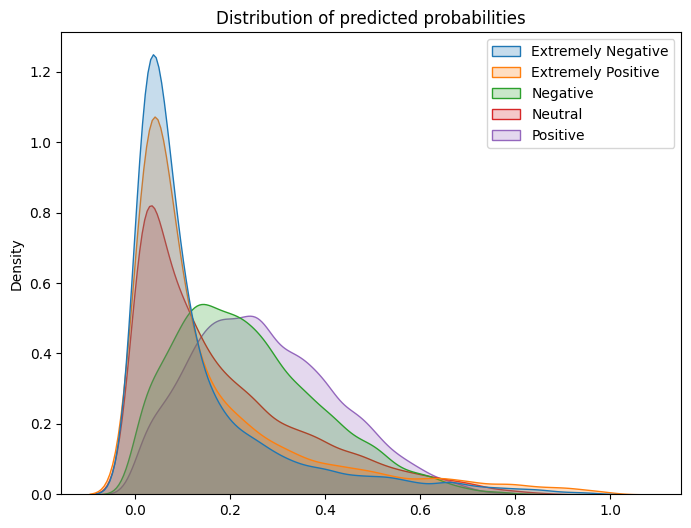

In [ ]:
plt.figure(figsize=(8,6))
sns.kdeplot(data=probas, fill=True, )
plt.title("Distribution of predicted probabilities")
plt.show()

## ***Result analysis***

* What can you conclude from the above probability distribution ?
* Does the model appear confident in its predictions ?
* How does it relate to the results obtained with the previous confusion matrices ?
  * ***Your** thoughts here*<br>
 On average, the model has the highest average probability of 0.274713 for the "Positive" category and the lowest average probability of 0.136675 for the "Extremely Negative" category, suggesting that the model is, on average, more confident in its predictions for the "Positive" category than for the other categories.
Relationship to the confusion matrix: This probability distribution information can be used in conjunction with the previous confusion matrix to assess model performance. If the model has a high average probability for specific categories and shows high accuracy in the confusion matrix matching the actual sentiment, the model can be said to perform confidently and well on these categories.

## ***Solution 2: Change the class distribution***

In [ ]:
{i: label_encoder.inverse_transform([i])[0] for i in range(5)}

{0: 'Extremely Negative',
 1: 'Extremely Positive',
 2: 'Negative',
 3: 'Neutral',
 4: 'Positive'}

In [ ]:
new_mapping = {
    0:2, # extremely negative => negative
    1:4 # extremely positive => positive
}

In [ ]:
df_reduced_labels = df.copy()
df_reduced_labels["Sentiment_enc"] = df_reduced_labels["Sentiment_enc"].map(new_mapping)
# replace the original sentiment encoding using the new mapping
category_orders = {"Sentiment_enc": ["Negative", "Neutral", "Positive"]}

print(round(df_reduced_labels.Sentiment_enc.value_counts(normalize=True)*100))
fig = px.histogram(df_reduced_labels, x="Sentiment_enc",
             color="Sentiment_enc",
             category_orders=category_orders,
             title="Updated sentiment distribution",
             text_auto=True,
            )

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [2,3,4],
        ticktext = ["Negative", "Neutral", "Positive"]
    )
)
fig.show()

4.0    54.0
2.0    46.0
Name: Sentiment_enc, dtype: float64


In [ ]:
X_reduced = df_reduced_labels['OriginalTweet']
y_reduced = df_reduced_labels['Sentiment_enc']

In [ ]:
# as before, train a logistic regression model with TF-IDF encoding and plot the results
from sklearn.linear_model import LogisticRegression

# Instantiate the Model class with text and labels (X and y), a logistic regression model, and a TF-IDF vectorizer
logistic_model = Model(X, y, LogisticRegression(max_iter=500), TfidfVectorizer)

# Fit the model to the training data
logistic_model.fit()

# Predict and generate a classification report
logistic_model.report()


                    precision    recall  f1-score   support

Extremely Negative       0.63      0.47      0.54      1189
Extremely Positive       0.68      0.53      0.60      1457
          Negative       0.51      0.53      0.52      2204
           Neutral       0.63      0.67      0.65      1681
          Positive       0.52      0.61      0.56      2460

          accuracy                           0.57      8991
         macro avg       0.59      0.56      0.57      8991
      weighted avg       0.58      0.57      0.57      8991

Confusion Matrix:
[[ 564    8  495   52   70]
 [  13  777   52   42  573]
 [ 257   49 1163  285  450]
 [  16   16  218 1120  311]
 [  39  296  334  287 1504]]


## ***Now it's your turn !***

### To achieve the ***"good"*** grade, test at least **two** more models of your choice and answer:
* Comment on the results you obtain, are they similar to the previous ones ? Why ?
    * ***Your** thoughts here*
    Model precision measures how accurately the model predicts each sentiment category. For example, a precision of 0.63 for the "Extremely Negative" category indicates the proportion of samples that the model correctly predicted as "Extremely Negative".
* Do you think the poor results are a byproduct of the model we choose or the quality of the data ?
    * ***Your** thoughts here*
    Poor results may be related to both aspects of model choice and data quality. The choice of model may affect its performance; if the model is not suitable for solving sentiment analysis problems, then it may not be able to capture the sentiment information in the text. In addition, the quality of the data is a key factor. If the training data is insufficient or unbalanced, the model may not be able to learn accurately. Also, if there is noise or labelling errors in the data, it can affect the performance of the model.
* If you had to improve those results, what would you do ?
    * ***Your** thoughts here*
  Data cleansing and pre-processing: ensuring that the text data in the dataset is properly cleansed and normalised to remove noise and improve data quality.
Data Enhancement: Increase the diversity of the dataset, which can be done by generating synthetic data to balance different sentiment categories.

### To achieve the ***"advanced"*** grade, try to improve or explain the results we obtained by experimenting with different techniques:
* For example, you could try some of those:
  * Balancing classes (oversampling or subsampling)
  * Applying class weights
  * Monitoring training curves
    * Implementing early stopping (models like XGBoost make it easier)
  * Applying normalization
  * Hyperparameter tuning
  * Or anything else you deem coherent

Random Forest Classifier<br>
Let's first train a Random Forest Classifier:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the Model class with text and labels (X and y), a Random Forest Classifier, and a TF-IDF vectorizer
random_forest_model = Model(X, y, RandomForestClassifier(random_state=42), TfidfVectorizer)

# Fit the model to the training data
random_forest_model.fit()

# Predict and generate a classification report
random_forest_model.report()


                    precision    recall  f1-score   support

Extremely Negative       0.65      0.40      0.49      1189
Extremely Positive       0.69      0.38      0.49      1457
          Negative       0.49      0.49      0.49      2204
           Neutral       0.57      0.74      0.64      1681
          Positive       0.48      0.59      0.53      2460

          accuracy                           0.53      8991
         macro avg       0.58      0.52      0.53      8991
      weighted avg       0.55      0.53      0.53      8991



The new model using the Random Forest classifier performed differently than the previous model on performance metrics such as precision, recall, and F1 score.
Precision and Recall: The new model has improved precision and recall for each sentiment category, especially in the "Neutral" category. This indicates that the new model performs better on certain sentiment categories.

Overall, the new random forest model performs better on some sentiment categories, especially in the "Neutral" category.

Support Vector Machine (SVM)<br>
Now, let's train a Support Vector Machine (SVM) classifier:

In [ ]:
from sklearn.svm import SVC

# Instantiate the Model class with text and labels (X and y), an SVM classifier, and a TF-IDF vectorizer
svm_model = Model(X, y, SVC(random_state=42), TfidfVectorizer)

# Fit the model to the training data
svm_model.fit()

# Predict and generate a classification report
svm_model.report()


                    precision    recall  f1-score   support

Extremely Negative       0.71      0.45      0.55      1189
Extremely Positive       0.77      0.49      0.60      1457
          Negative       0.53      0.59      0.56      2204
           Neutral       0.66      0.64      0.65      1681
          Positive       0.53      0.69      0.60      2460

          accuracy                           0.59      8991
         macro avg       0.64      0.57      0.59      8991
      weighted avg       0.62      0.59      0.59      8991



The new SVM model performs better on performance metrics such as precision, recall, and F1 score, which are significant improvements over the previous model.
Precision and Recall: The new SVM model shows significant improvements in precision and recall for each sentiment category, especially in the "Extremely Negative", "Extremely Positive", and "Positive" categories. This indicates that the new model performs better on a wider range of emotion categories, especially in recognising extreme emotions.
F1 Score: The average F1 score of the new model is 0.59, which is higher than the previous two models.

Overall, the new SVM model showed better performance in the sentiment analysis task, especially in terms of recall, which means that it is better able to capture a wide range of sentiment categories. This may be due
to SVM's strength in handling high dimensional data and non-linear relationships.


Tweak the hyperparameters of the SVM classifier, such as the C-value and kernel function, to further optimise performance.

